In [6]:
1

1

In [7]:
import numpy as np
import tensorflow.keras
from tensorflow import keras
import torch
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, AveragePooling1D, Conv2D, MaxPooling2D,ReLU
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model #save and load models
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
import IPython.display as ipd
from kymatio import Scattering1D
import hitdifferentparts
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pescador
import random
import os
import librosa
import pickle

In [8]:
#make the model
def create_model(J,Q,order,input_x,input_y,k_size,layer_size,nchan_out):
    #fname = random.choice(os.listdir(path_to_train))
    #rand_audio = os.path.join(path_to_train,fname)
    #y,sr = librosa.load(rand_audio)
    #N = len(y)
    #scattering = Scattering1D(J = J,shape=(N,), Q = Q, max_order=order)
    
    #Sy = getsc_new(torch.Tensor(y),J,Q,order,scattering).T
    #nrow, ncol = Sy.shape 
    nrow = input_x
    ncol = input_y
    #naudio = batch_size         # number of images in batch
    nchan_in = 1       # number of input channels.  1 since it is BW
    #input_shape = (nrow,ncol,nchan_in)  # input shape of 1 image
    input_shape = (input_x,input_y)#Sy.shape
    #batch_shape = (naudio,nrow,ncol,nchan_in)  # shape of image batch
    #x = Sy.reshape(batch_shape)
    kernel_size = (k_size,)
    #nchan_out = 16

    K.clear_session()
    model=Sequential()
    #1 conv layer +  1 batch normalization + nonlinear activation + pooling
    model.add(Conv1D(input_shape=input_shape, filters=nchan_out,
                     kernel_size=kernel_size, padding="same",name='conv1'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(AveragePooling1D(pool_size=(4,)))
    
   #second time
    model.add(Conv1D(filters=nchan_out,
                     kernel_size=kernel_size, padding="same",name='conv2' ))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(AveragePooling1D(pool_size=(4,)))
    
    #third time
    if layer_size>=3:
        model.add(Conv1D(filters=nchan_out,
                         kernel_size=kernel_size, padding="same",name='conv3' ))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(AveragePooling1D(pool_size=(4,)))
        if layer_size==4:
        #fourth time
            model.add(Conv1D(filters=nchan_out,
                             kernel_size=kernel_size, padding="same",name='conv4' ))
            model.add(BatchNormalization())
            model.add(Activation("relu"))
            model.add(AveragePooling1D(pool_size=(2,)))
            if layer_size ==5:
                model.add(Conv1D(filters=nchan_out,
                             kernel_size=kernel_size, padding="same",name='conv5' ))
                model.add(BatchNormalization())
                model.add(Activation("relu"))
                model.add(AveragePooling1D(pool_size=(2,)))

    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    #what activation should be chosen for last layer, for regression problem? should be a linear function
    model.add(Dense(5, activation='linear')) #output layer that corresponds to the 5 physical parameters.


    # Compile the model
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    
    #print(model.summary())
    return model

In [9]:
features_dir = "/scratch/vl1019/han2020fa_data/han2020fa_sc-pkl/"
os.listdir(features_dir)

['scattering_J-14_Q-01_order2_fold-train.pkl',
 'scattering_J-10_Q-01_order1_fold-test.pkl',
 'scattering_J-12_Q-01_order2_fold-test.pkl',
 'scattering_J-14_Q-01_order1_fold-train.pkl',
 'scattering_J-06_Q-01_order1_fold-train.pkl',
 'scattering_J-12_Q-01_order1_fold-train.pkl',
 'scattering_J-10_Q-01_order2_fold-train.pkl',
 'scattering_J-14_Q-01_order1_fold-test.pkl',
 'scattering_J-12_Q-01_order1_fold-test.pkl',
 'scattering_J-06_Q-01_order1_fold-test.pkl',
 'scattering_J-14_Q-01_order1_fold-val.pkl',
 'scattering_J-08_Q-01_order2_fold-train.pkl',
 'scattering_J-12_Q-01_order2_fold-train.pkl',
 'scattering_J-14_Q-01_order2_fold-test.pkl',
 'scattering_J-08_Q-01_order2_fold-val.pkl',
 'scattering_J-12_Q-01_order2_fold-val.pkl',
 'scattering_J-06_Q-01_order2_fold-val.pkl',
 'scattering_J-08_Q-01_order1_fold-val.pkl',
 'scattering_J-10_Q-01_order1_fold-val.pkl',
 'scattering_J-10_Q-01_order1_fold-train.pkl',
 'scattering_J-06_Q-01_order1_fold-val.pkl',
 'scattering_J-08_Q-01_order2_fol

In [10]:
# open J-8,Q=1,O=2 pkl file
J = 8
Q = 1
order = 2
pkl_path = '/scratch/hh2263/drum_data/pkl_data/scattering_J-08_Q-01_order2.pkl'
pkl_file = open(pkl_path, 'rb')
Sy_train,y_train = pickle.load(pkl_file) 

pkl_path_val = '/scratch/hh2263/drum_data/val/J_8_Q_1_order_2.pkl'
pkl_val = open(pkl_path_val,'rb')
Sy_val,y_val = pickle.load(pkl_val)
Sy_val = Sy_val.reshape((Sy_val.shape[2],Sy_val.shape[0],Sy_val.shape[1]))

pkl_path_test = os.path.join(features_dir,"scattering_J-08_Q-01_order2_fold-test.pkl")
pkl_test = open(pkl_path_test,'rb')
Sy_test,y_test = pickle.load(pkl_test)


In [11]:
#fix everybody's physical parameters first (p and D should be log)
#print(np.log10(y_train[0,3]),y_train[0,3])
import math
for idx in range(2,4):
    y_train[:,idx] = [math.log10(i) for i in y_train[:,idx]]
    y_test[:,idx] = [math.log10(i) for i in y_test[:,idx]]
    y_val[:,idx] = [math.log10(i) for i in y_val[:,idx]]

In [12]:
input_x = Sy_train.shape[1]
input_y = Sy_train.shape[2]
print(Sy_train.shape,Sy_val.shape,y_train.shape,y_val.shape,input_x,input_y)

(82224, 128, 43) (7776, 128, 43) (82224, 5) (7776, 5) 128 43


In [13]:
df_train = pd.read_csv("./train_param.csv")
df_test = pd.read_csv("./test_param.csv")
df_val = pd.read_csv("./val_param.csv")
df_full = pd.read_csv("./diffshapes_param.csv")

# normalization of the physical parameters
params = df_train.values[:,1:-1]
#fix the p,D params to log scale
params.shape

(82224, 5)

In [14]:
for idx in range(2,4):
    params[:,idx] = [math.log10(i) for i in params[:,idx]]

In [15]:
scaler = MinMaxScaler()
scaler.fit(params)

#normalize training and validation set
y_train_normalized = scaler.transform(y_train)
y_val_normalized = scaler.transform(y_val)
y_test_normalized = scaler.transform(y_test)

In [16]:
print(y_train_normalized.shape)

(82224, 5)


In [17]:
output_dir = "../output/"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_filepath = os.path.join(output_dir, "cp_best2.h5")
log_filepath = os.path.join(output_dir, 'train_log.csv')

callbacks = []
callbacks.append(EarlyStopping(monitor='val_loss',patience=0,verbose=1))
callbacks.append(ModelCheckpoint(model_filepath, save_best_only=True))
callbacks.append(CSVLogger(log_filepath))

In [18]:
epoch = 1
trial_dir = "../output/"
epoch_str = "epoch-" + str(epoch).zfill(3)
epoch_network_path = os.path.join(
   trial_dir, "_".join(["j8o2", epoch_str]) + ".h5")
print(epoch_network_path)

../output/j8o2_epoch-001.h5


In [35]:
trial_dir = "../output/"
best_validation_loss = np.inf
n = Sy_train.shape[0]
steps_per_epoch = 10
bs = 128
m = bs*steps_per_epoch
idx = np.arange(0,n,1)
val_loss=[]
model=create_model(J,Q,order,input_x,input_y,k_size=8,layer_size=4,nchan_out=16)
for epoch in range(30):
    np.random.shuffle(idx)
    Sy_temp = Sy_train[idx[:m],:,:]
    y_temp = y_train_normalized[idx[:m],:]
    
    hist = model.fit(Sy_temp,
                y_temp,
                epochs=1,
                verbose=2,
                batch_size=bs,
                validation_data = (Sy_val,y_val_normalized),
                use_multiprocessing=False)
    validation_loss = hist.history['val_loss'][0]
    val_loss.append(validation_loss)
    if True:#validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        epoch_str = "epoch-" + str(epoch).zfill(3)
        epoch_network_path = os.path.join(
           trial_dir, "_".join(["j8o2", epoch_str]) + ".ckpt")
        model.save(epoch_network_path)

Train on 1280 samples, validate on 7776 samples
1280/1280 - 1s - loss: 0.9205 - mean_squared_error: 0.9205 - val_loss: 0.2430 - val_mean_squared_error: 0.2430
Train on 1280 samples, validate on 7776 samples
1280/1280 - 0s - loss: 0.3969 - mean_squared_error: 0.3969 - val_loss: 0.2138 - val_mean_squared_error: 0.2138
Train on 1280 samples, validate on 7776 samples
1280/1280 - 0s - loss: 0.2837 - mean_squared_error: 0.2837 - val_loss: 0.1904 - val_mean_squared_error: 0.1904
Train on 1280 samples, validate on 7776 samples
1280/1280 - 0s - loss: 0.2283 - mean_squared_error: 0.2283 - val_loss: 0.1689 - val_mean_squared_error: 0.1689
Train on 1280 samples, validate on 7776 samples
1280/1280 - 0s - loss: 0.1898 - mean_squared_error: 0.1898 - val_loss: 0.1495 - val_mean_squared_error: 0.1495
Train on 1280 samples, validate on 7776 samples
1280/1280 - 0s - loss: 0.1634 - mean_squared_error: 0.1634 - val_loss: 0.1341 - val_mean_squared_error: 0.1341
Train on 1280 samples, validate on 7776 sample

In [24]:
class DataGenerator(tensorflow.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, Sy_train, y_train, batch_size=32, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.Sy_train = Sy_train
        self.y_train = y_train
        self.shuffle = shuffle
        #self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.Sy_train.shape[0] / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = np.arange(0,self.Sy_train.shape[0],1)
        np.random.shuffle(indexes)
        
        # Generate data
        X, y = self.__data_generation(indexes[:self.batch_size])

        return X, y

#    def on_epoch_end(self):
#        'Updates indexes after each epoch'
#        self.indexes = np.arange(len(self.list_IDs))
#        if self.shuffle == True:
#            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = self.Sy_train[list_IDs_temp,:,:]
        y = self.y_train[list_IDs_temp,:]

        return X, y
parameters = {'batch_size': 64,
          'shuffle': True}
training_generator = DataGenerator(Sy_train, y_train_normalized, **parameters)

In [ ]:
model2=create_model(J,Q,order,input_x,input_y,k_size=8,layer_size=4,nchan_out=16)
#model2.load_weights(model_filepath)
model2.fit(training_generator,
          steps_per_epoch=10,
          verbose=2,
          callbacks = callbacks,
          epochs = 10, 
         validation_data=(Sy_val,y_val_normalized),
          use_multiprocessing=True)

Epoch 1/10


In [12]:
model2=create_model(J,Q,order,input_x,input_y,k_size=8,layer_size=4,nchan_out=16)
model2.load_weights("../output/j8o2_epoch-007.ckpt")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [13]:
#evaluate on training set
model2.evaluate(Sy_train,y_train_normalized)

82224/82224 [==============================] - 10s 124us/sample - loss: 0.1379 - mean_squared_error: 0.1379


[0.13790690756233825, 0.13790679]

In [20]:
#evaluate on test set
model2.evaluate(Sy_test,y_test_normalized)

10000/10000 [==============================] - 1s 102us/sample - loss: 0.1386 - mean_squared_error: 0.1386


[0.13861700139045716, 0.13861698]

In [21]:
#evaluate on val set
model2.evaluate(Sy_val,y_val_normalized)

7776/7776 [==============================] - 1s 101us/sample - loss: 0.0800 - mean_squared_error: 0.0800


[0.08004938519785924, 0.08004941]

## test on training set

In [22]:
example = df_train.values[0,:]
name = str(example[0])+"_sound.wav"
#p, d is original number
params = example[1:]
y,fs = librosa.load("/scratch/hh2263/drum_data/train/"+name)
print(params)

[3641.267682215784 0.14912260113032105 0.9748392162093932
 0.008955332878189611 0.6462749409737613 'train']


In [58]:
params_tolog = params[:5]
#turn to log
for i in [2,3]:
    params_tolog[i]=np.log10(params_tolog[i])
#then normalize
params_tolog_normalized = scaler.transform(params_tolog.reshape(1,-1))

print(params_tolog_normalized)

[[0.25238744 0.4797219         nan        nan 0.64594265]]


In [62]:
print(y_train_normalized[0,:])

[0.25238744 0.4797219  0.92743857 0.39040254 0.64594265]


In [43]:
scattering = Scattering1D(J=J, shape=(2**15,), Q=Q, max_order=order)
Sx = np.array(scattering(torch.Tensor(y)).T)
predicted = model2.predict(Sx.reshape((1,128,43)))#this p,D is the log number
#print(predicted,scaler.transform(params[:5].reshape(1,-1)),np.square(predicted-scaler.transform(params[:5].reshape(1,-1))).mean())
print(predicted)#this p,D is the log number

[[0.2730493  0.7844304  0.53565776 0.3154272  0.21816818]]


In [26]:
##example 2
#model2=create_model(J,Q,order,input_x,input_y,k_size=8,layer_size=4,nchan_out=16)
model2.load_weights("../output/j8o2_epoch-001.ckpt")
i=902
original = y_test_normalized[i,:]
Sx = Sy_test[i,:,:]
recovered = model2.predict(Sx.reshape((1,128,43)))
print(original,recovered,sum(sum(Sx)))

[0.69282834 0.6220154  0.51365813 0.09954005 0.30691902] [[0.01014788 0.21470457 0.18532936 0.09851347 0.03551538]] 9.772730382918098


In [38]:
model2=create_model(J,Q,order,input_x,input_y,k_size=8,layer_size=4,nchan_out=16)
recovereds=[]
for i in range(0,30):
    if i<10:
        num="00"+str(i)
    else:
        num="0"+str(i)
    model2.load_weights("../output/j8o2_epoch-"+num+".ckpt")
    idx=900
    original = y_test_normalized[idx,:]
    Sx = Sy_test[idx,:,:]
    recovered = model2.predict(Sx.reshape((1,128,43)))
    recovereds.append(recovered)
print(original,recovereds)

[0.18508676 0.15778566 0.83393416 0.6973833  0.38978658] [array([[0.04591782, 0.02651004, 0.0420649 , 0.04022747, 0.05417976]],
      dtype=float32), array([[0.07986928, 0.05142371, 0.06809826, 0.07133659, 0.10372162]],
      dtype=float32), array([[0.10139805, 0.07193292, 0.09374915, 0.09828396, 0.15363918]],
      dtype=float32), array([[0.12689157, 0.0859156 , 0.12560502, 0.13082716, 0.19202164]],
      dtype=float32), array([[0.15205894, 0.09973247, 0.15990762, 0.15321085, 0.23898062]],
      dtype=float32), array([[0.17651643, 0.10642136, 0.1892853 , 0.181182  , 0.27262926]],
      dtype=float32), array([[0.20039372, 0.11751549, 0.22942689, 0.20157209, 0.30574536]],
      dtype=float32), array([[0.23135908, 0.11681305, 0.24833131, 0.22186542, 0.32985726]],
      dtype=float32), array([[0.24732502, 0.12336875, 0.2688112 , 0.22865376, 0.36601382]],
      dtype=float32), array([[0.2604821 , 0.1277914 , 0.29774553, 0.2471487 , 0.39191043]],
      dtype=float32), array([[0.2732913 , 0.

(array([113.,  98., 114., 120., 108.,  73., 108., 112., 109., 107., 128.,
        109., 111.,  94., 107., 117., 102.,  97., 111., 109.,  99.,  91.,
        109.,  83.,  72.,  89., 100.,  92.,  76.,  83.,  78.,  99.,  86.,
        104.,  89.,  94.,  92.,  80.,  80.,  95., 104.,  98.,  99., 100.,
         92.,  78.,  96.,  84., 113., 109.,  90., 111., 109.,  97.,  97.,
        103.,  89., 110.,  99.,  96.,  94.,  97., 108.,  92.,  92., 114.,
         94., 104.,  80.,  88., 106.,  81.,  92.,  86., 102., 104.,  87.,
         90., 101.,  85., 121., 111., 114., 114., 111., 117., 117., 108.,
         92.,  93., 125.,  95., 104., 106., 110., 105.,  96., 106., 131.,
        115.]),
 array([2.41196530e-06, 1.00021660e-02, 2.00019201e-02, 3.00016742e-02,
        4.00014283e-02, 5.00011824e-02, 6.00009365e-02, 7.00006905e-02,
        8.00004446e-02, 9.00001987e-02, 9.99999528e-02, 1.09999707e-01,
        1.19999461e-01, 1.29999215e-01, 1.39998969e-01, 1.49998723e-01,
        1.59998477e-01, 1.6999

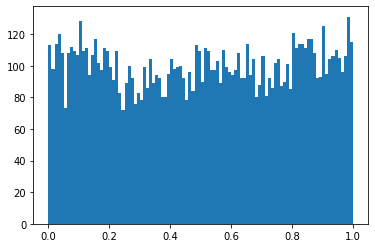

In [107]:
#y_train_normalized
plt.hist(y_va_normalized[:,0],100)  

(array([886., 909., 868., 909., 851., 915., 832., 894., 937., 939., 888.,
        891., 860., 888., 913., 916., 882., 871., 893., 889., 766., 742.,
        751., 743., 862., 822., 796., 730., 785., 777., 786., 760., 816.,
        768., 751., 764., 791., 775., 795., 759., 841., 768., 763., 755.,
        790., 794., 755., 817., 752., 762., 770., 753., 783., 800., 787.,
        775., 767., 791., 725., 788., 807., 753., 746., 758., 780., 774.,
        775., 787., 800., 759., 831., 771., 765., 751., 796., 723., 814.,
        770., 795., 747., 858., 895., 951., 856., 908., 904., 869., 866.,
        908., 877., 901., 886., 870., 889., 900., 883., 871., 882., 946.,
        896.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.

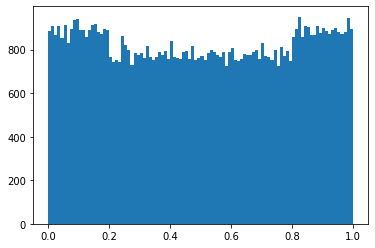

In [106]:
plt.hist(y_train_normalized[:,1],100)

In [44]:
#scaler is according to the log number 
predicted_recovered = scaler.inverse_transform(predicted)

In [45]:
predicted_recovered

array([[ 3.8879197e+03,  2.3748538e-01, -1.6961155e+00, -2.4227707e+00,
         2.1894422e-01]], dtype=float32)

In [46]:
predicted_original = predicted_recovered[0]
for i in [2,3]:
    predicted_original[i]=10**predicted_original[i]

print(predicted_original)

[3.8879197e+03 2.3748538e-01 2.0131888e-02 3.7777156e-03 2.1894422e-01]


In [48]:
import ftm 
y2 = ftm.getsounds_imp(10,10,predicted_original[0],
                       predicted_original[1],
                       predicted_original[2],
                       predicted_original[3],
                       predicted_original[4],22050)

In [49]:
ipd.Audio(y,rate=22050)

In [50]:
ipd.Audio(y2,rate=22050)

In [54]:
import soundfile as sf
sf.write('original.wav', y/max(y), 22050)
sf.write('recovered.wav',y2/max(y2),22050)

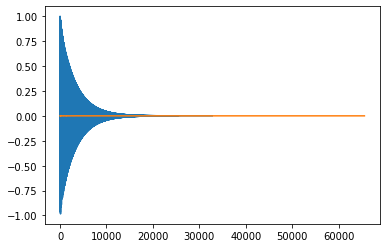

In [51]:
import matplotlib.pyplot as plt
plt.plot(y)
plt.plot(y2)

discussion
- even though the loss is 0.03 for this particular case, the recovered physical parameters are still very off. need to take into account the ratio between error and their scale. 
- each physical parameter has different tolerance of error too. does mse account for that? 

## see model output layer by layer
there isn't much divergence across the dataset, see if it results from batchnormalization makes a lot of the data be negative

In [19]:
#load the model after first epoch of training
model=create_model(J,Q,order,input_x,input_y,k_size=8,layer_size=4,nchan_out=16)
num="001"
model.load_weights("../output/j8o2_epoch-"+num+".ckpt")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [20]:
minput = model.get_layer('conv1')
mhidden = model.get_layer('batch_normalization')
testmodel = Sequential()
testmodel.add(minput)
testmodel.add(mhidden)
testmodel.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [21]:
#after conv1d and batch normalization, print out the prediction
output = testmodel.predict(Sy_test[4,:,:].reshape((1,128,43)))
output_vec = output.reshape((1,128*16))
num_pos = sum(sum(output_vec>0))
num_neg = 128*16 - num_pos
print('number of output above zero is '+ str(num_pos) + ', below zero is '+ str(num_neg) )

number of output above zero is 778, below zero is 1270


alternate batch norm and conv 1 layer

In [22]:
#make the model
def create_model2(J,Q,order,input_x,input_y,k_size,layer_size,nchan_out):
    #fname = random.choice(os.listdir(path_to_train))
    #rand_audio = os.path.join(path_to_train,fname)
   #y,sr = librosa.load(rand_audio)
    #N = len(y)
    #scattering = Scattering1D(J = J,shape=(N,), Q = Q, max_order=order)
    
    #Sy = getsc_new(torch.Tensor(y),J,Q,order,scattering).T
    #nrow, ncol = Sy.shape 
    nrow = input_x
    ncol = input_y
    #naudio = batch_size         # number of images in batch
    nchan_in = 1       # number of input channels.  1 since it is BW
    #input_shape = (nrow,ncol,nchan_in)  # input shape of 1 image
    input_shape = (input_x,input_y)#Sy.shape
    #batch_shape = (naudio,nrow,ncol,nchan_in)  # shape of image batch
    #x = Sy.reshape(batch_shape)
    kernel_size = (k_size,)
    #nchan_out = 16

    K.clear_session()
    model=Sequential()
    #1 conv layer +  1 batch normalization + nonlinear activation + pooling
    model.add(BatchNormalization(input_shape=input_shape))
    model.add(Conv1D(filters=nchan_out,
                     kernel_size=kernel_size, padding="same",name='conv1'))
   
    model.add(Activation("relu"))
    model.add(AveragePooling1D(pool_size=(4,)))
    
   #second time
    model.add(Conv1D(filters=nchan_out,
                     kernel_size=kernel_size, padding="same",name='conv2' ))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(AveragePooling1D(pool_size=(4,)))
    
    #third time
    if layer_size>=3:
        model.add(Conv1D(filters=nchan_out,
                         kernel_size=kernel_size, padding="same",name='conv3' ))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(AveragePooling1D(pool_size=(4,)))
        if layer_size==4:
        #fourth time
            model.add(Conv1D(filters=nchan_out,
                             kernel_size=kernel_size, padding="same",name='conv4' ))
            model.add(BatchNormalization())
            model.add(Activation("relu"))
            model.add(AveragePooling1D(pool_size=(2,)))
            if layer_size ==5:
                model.add(Conv1D(filters=nchan_out,
                             kernel_size=kernel_size, padding="same",name='conv5' ))
                model.add(BatchNormalization())
                model.add(Activation("relu"))
                model.add(AveragePooling1D(pool_size=(2,)))

    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    #what activation should be chosen for last layer, for regression problem? should be a linear function
    model.add(Dense(5, activation='linear')) #output layer that corresponds to the 5 physical parameters.


    # Compile the model
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    
    #print(model.summary())
    return model

In [23]:
model_r=create_model2(J,Q,order,input_x,input_y,k_size=8,layer_size=4,nchan_out=16)
model_r.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 128, 43)           172       
_________________________________________________________________
conv1 (Conv1D)               (None, 128, 16)           5520      
_________________________________________________________________
activation (Activation)      (None, 128, 16)           0         
_________________________________________________________________
average_pooling1d (AveragePo (None, 32, 16)            0         
_________________________________________________________________
conv2 (Conv1D)               (None, 32, 16)            2064      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 16)            64        
_________________________________________________________________
activation_1 (Activation)    (None, 32, 16)            0

In [23]:
trial_dir = "../output/"
best_validation_loss = np.inf
n = Sy_train.shape[0]
steps_per_epoch = 10
bs = 64
m = bs*steps_per_epoch
idx = np.arange(0,n,1)
val_loss=[]
#model=create_model(J,Q,order,input_x,input_y,k_size=8,layer_size=4,nchan_out=16)
for epoch in range(30):
    np.random.shuffle(idx)
    Sy_temp = Sy_train[idx[:m],:,:]
    y_temp = y_train_normalized[idx[:m],:]
    
    hist = model_r.fit(Sy_temp,
                y_temp,
                epochs=1,
                verbose=2,
                batch_size=bs,
                validation_data = (Sy_val,y_val_normalized),
                use_multiprocessing=False)
    validation_loss = hist.history['val_loss'][0]
    val_loss.append(validation_loss)
    if True:#validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        epoch_str = "epoch-" + str(epoch).zfill(3)
        epoch_network_path = os.path.join(
           trial_dir, "_".join(["j8o2", epoch_str]) + "-r.ckpt")
        model_r.save(epoch_network_path)

Train on 640 samples, validate on 7776 samples


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/hh2263/miniconda3/envs/drum-1.15/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-51de7721e2dc>", line 21, in <module>
    use_multiprocessing=False)
  File "/home/hh2263/miniconda3/envs/drum-1.15/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training.py", line 727, in fit
    use_multiprocessing=use_multiprocessing)
  File "/home/hh2263/miniconda3/envs/drum-1.15/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_arrays.py", line 675, in fit
    steps_name='steps_per_epoch')
  File "/home/hh2263/miniconda3/envs/drum-1.15/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_arrays.py", line 394, in model_iteration
    batch_outs = f(ins_batch)
  File "/home/hh2263/miniconda3/envs/drum-1.15/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3

TypeError: can only concatenate str (not "list") to str

In [50]:
model=create_model2(J,Q,order,input_x,input_y,k_size=8,layer_size=4,nchan_out=16)
num="001"
model.load_weights("../output/j8o2_epoch-"+num+"-r.ckpt")

In [47]:
minput = model.get_layer('batch_normalization')
mhidden = model.get_layer('conv1')
testmodel_r = Sequential()
testmodel_r.add(minput)
testmodel_r.add(mhidden)
testmodel_r.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [26]:
#after batch norm and conv1, print out the prediction
output_r = testmodel_r.predict(Sy_train[1800,:,:].reshape((1,128,43)))
output_vec_r = output_r.reshape((1,128*16))
num_pos = sum(sum(output_vec_r>0))
num_neg = 128*16 - num_pos
print('number of output above zero is '+ str(num_pos) + ', below zero is '+ str(num_neg) )

number of output above zero is 864, below zero is 1184


print out output value positive vs negative after the second batch norm

In [52]:
testmodel_r = Sequential()
testmodel_r.add(model.get_layer('batch_normalization'))
testmodel_r.add(model.get_layer('conv1'))
testmodel_r.add(model.get_layer('activation'))
testmodel_r.add(model.get_layer('average_pooling1d_1'))
testmodel_r.add(model.get_layer('conv2'))
testmodel_r.add(model.get_layer('batch_normalization_1'))
testmodel_r.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [53]:
output_r = testmodel_r.predict(Sy_train[2,:,:].reshape((1,128,43)))
output_vec_r = output_r.reshape((1,32*16))
num_pos = sum(sum(output_vec_r>0))
num_neg = 128*16 - num_pos
print('number of output above zero is '+ str(num_pos) + ', below zero is '+ str(num_neg) )

number of output above zero is 336, below zero is 1712


In [54]:
model=create_model(J,Q,order,input_x,input_y,k_size=8,layer_size=4,nchan_out=16)
num="001"
model.load_weights("../output/j8o2_epoch-"+num+".ckpt")
testmodel = Sequential()
testmodel.add(model.get_layer('conv1'))
testmodel.add(model.get_layer('batch_normalization'))
testmodel.add(model.get_layer('activation'))
testmodel.add(model.get_layer('average_pooling1d_1'))
testmodel.add(model.get_layer('conv2'))
testmodel.add(model.get_layer('batch_normalization_1'))
testmodel.compile(loss='mse', optimizer='adam', metrics=['mse'])


In [55]:
output = testmodel.predict(Sy_train[1900,:,:].reshape((1,128,43)))
output_vec = output_r.reshape((1,32*16))
num_pos = sum(sum(output_vec>0))
num_neg = 128*16 - num_pos
print('number of output above zero is '+ str(num_pos) + ', below zero is '+ str(num_neg) )

number of output above zero is 336, below zero is 1712


## train model with log scattering

In [57]:
trial_dir = "../output/"
best_validation_loss = np.inf
n = Sy_train.shape[0]
steps_per_epoch = 10
bs = 128
m = bs*steps_per_epoch
idx = np.arange(0,n,1)
val_loss=[]
model=create_model(J,Q,order,input_x,input_y,k_size=8,layer_size=4,nchan_out=16)
for epoch in range(30):
    np.random.shuffle(idx)
    Sy_temp = np.log(Sy_train[idx[:m],:,:])
    y_temp = y_train_normalized[idx[:m],:]
    
    hist = model.fit(Sy_temp,
                y_temp,
                epochs=1,
                verbose=2,
                batch_size=bs,
                validation_data = (Sy_val,y_val_normalized),
                use_multiprocessing=False)
    validation_loss = hist.history['val_loss'][0]
    val_loss.append(validation_loss)
  #  if True:#validation_loss < best_validation_loss:
  #      best_validation_loss = validation_loss
  #      epoch_str = "epoch-" + str(epoch).zfill(3)
  #      epoch_network_path = os.path.join(
  #         trial_dir, "_".join(["j8o2", epoch_str]) + "-log.ckpt")
  #      model.save(epoch_network_path)

/home/hh2263/miniconda3/envs/drum-1.15/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/home/hh2263/miniconda3/envs/drum-1.15/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':


Train on 1280 samples, validate on 7776 samples
1280/1280 - 1s - loss: 0.3227 - mean_squared_error: 0.3227 - val_loss: 0.2325 - val_mean_squared_error: 0.2325
Train on 1280 samples, validate on 7776 samples


/home/hh2263/miniconda3/envs/drum-1.15/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/home/hh2263/miniconda3/envs/drum-1.15/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':


1280/1280 - 0s - loss: 0.2647 - mean_squared_error: 0.2647 - val_loss: 0.1775 - val_mean_squared_error: 0.1775
Train on 1280 samples, validate on 7776 samples
1280/1280 - 0s - loss: 0.2125 - mean_squared_error: 0.2125 - val_loss: 0.1226 - val_mean_squared_error: 0.1226
Train on 1280 samples, validate on 7776 samples
1280/1280 - 0s - loss: 0.1587 - mean_squared_error: 0.1587 - val_loss: 0.0765 - val_mean_squared_error: 0.0765
Train on 1280 samples, validate on 7776 samples
1280/1280 - 0s - loss: 0.1195 - mean_squared_error: 0.1195 - val_loss: 0.0466 - val_mean_squared_error: 0.0466
Train on 1280 samples, validate on 7776 samples
1280/1280 - 0s - loss: 0.0964 - mean_squared_error: 0.0964 - val_loss: 0.0340 - val_mean_squared_error: 0.0340
Train on 1280 samples, validate on 7776 samples
1280/1280 - 0s - loss: 0.0895 - mean_squared_error: 0.0895 - val_loss: 0.0312 - val_mean_squared_error: 0.0312
Train on 1280 samples, validate on 7776 samples
1280/1280 - 0s - loss: 0.0875 - mean_squared_e

In [78]:
i = 1003
predicted = model.predict(Sy_train[i,:,:].reshape((1,128,43)))
print(predicted,y_train_normalized[i,:])

[[0.49586144 0.5079881  0.4994295  0.49253783 0.49421838]] [0.10724836 0.27927651 0.39158989 0.36553537 0.10732666]


In [63]:
print(y_train_normalized[1900,:])

[0.64753915 0.84055801 0.05809834 0.43057124 0.18593313]
